In [3]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
train_df = pd.read_csv('Train.csv')
test_df = pd.read_csv('Test.csv')
sample_df = pd.read_csv('sample_submission.csv')

In [5]:
train_df.sample(5)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
591,465006,Male,No,39,Yes,Entertainment,5.0,Low,1.0,Cat_6,A
4057,465237,Male,Yes,68,Yes,Lawyer,NaN,High,2.0,Cat_6,D
6011,465743,Female,Yes,50,Yes,Artist,1.0,Average,5.0,Cat_2,C
1016,461962,Male,Yes,59,Yes,Entertainment,1.0,Average,3.0,Cat_6,B
1481,465713,Male,Yes,59,Yes,Artist,0.0,Average,4.0,Cat_6,C


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


<center><h3><i>EDA and Data Cleaning</i></h3></center>
<hr>
<b><i>Remove Duplicate Data</i></b>

In [7]:
def remove_duplicate(df):
    print("No. of Rows BEFORE Removing Duplicates: ", df.shape[0])
    df.drop_duplicates(keep="first", inplace=True) 
    print('No. of Rows AFTER Removing Duplicates: ', df.shape[0])
    
    # Make sure all IDs are unique
    if df['ID'].nunique() != len(df['ID']):
        # If exist, examine rows with duplicate IDs
        id_list = Counter(df['ID'].values)
        duplicate_id = [ID for ID, freq in id_list.iteritems() if freq > 1]
        
        print('Duplicate IDs with different column values:')
        display(df[df['ID'].isin(duplicate_id)])
    
    return df

In [8]:
print('TRAIN DATASET')
train_df = remove_duplicate(train_df)
print('\nTEST DATASET')
test_df = remove_duplicate(test_df)

TRAIN DATASET
No. of Rows BEFORE Removing Duplicates:  8068
No. of Rows AFTER Removing Duplicates:  8068

TEST DATASET
No. of Rows BEFORE Removing Duplicates:  2627
No. of Rows AFTER Removing Duplicates:  2627


<br>
<b><i>Filling Null Values</i></b>

In [9]:
# Count Null Values per Feature
def count_null(df):
    nulls = df.isnull().sum()
    columns = [col for col, null in [*nulls.items()] if null != 0]
    
    for col in columns :
        print('Column {} has {} null values. Data type {}'.format(col, nulls[col], str(df[col].dtype).upper()))

In [10]:
count_null(train_df)

Column Ever_Married has 140 null values. Data type OBJECT
Column Graduated has 78 null values. Data type OBJECT
Column Profession has 124 null values. Data type OBJECT
Column Work_Experience has 829 null values. Data type FLOAT64
Column Family_Size has 335 null values. Data type FLOAT64
Column Var_1 has 76 null values. Data type OBJECT


In [11]:
count_null(test_df)

Column Ever_Married has 50 null values. Data type OBJECT
Column Graduated has 24 null values. Data type OBJECT
Column Profession has 38 null values. Data type OBJECT
Column Work_Experience has 269 null values. Data type FLOAT64
Column Family_Size has 113 null values. Data type FLOAT64
Column Var_1 has 32 null values. Data type OBJECT


<br>
<b>Work Experience</b> and <b>Family Size</b> columns have the most null values.
<br>
We will impute <b>Work Experience</b> based on the mean value per (Gender, Age, Graduated, Spending Score)<br>
We will impute <b>Family Size</b> based on the mean value per (Gender, Ever Married, Age, Graduated, Spending Score)<br>
(These demographic grouping choices are arbitrary)<br>
For the rest of the empty values, we will impute based on Age, Gender, and Spending Score (because they are the only columns with no missing value)

In [12]:
# Combine train and test data for convenience
train_df['is_train'] = 1
test_df['is_train'] = 0
combined_df = pd.concat([train_df, test_df], ignore_index=True)
combined_df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,is_train
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D,1
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A,1
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B,1
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B,1
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A,1


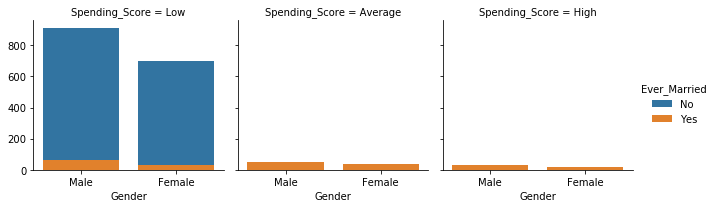

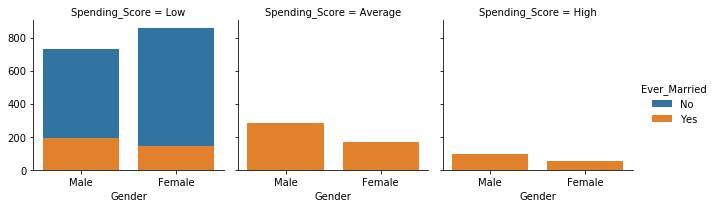

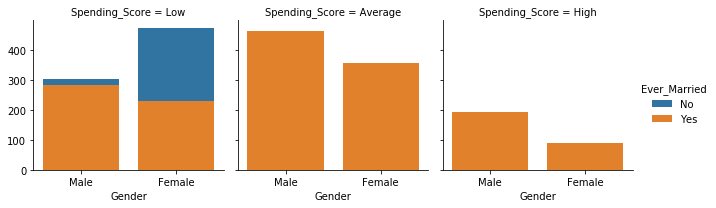

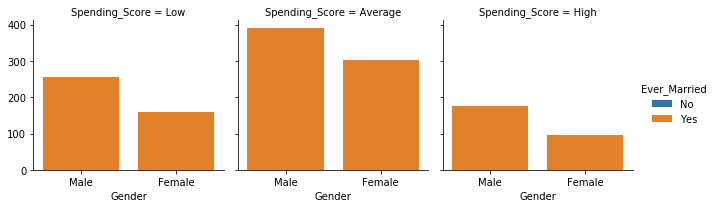

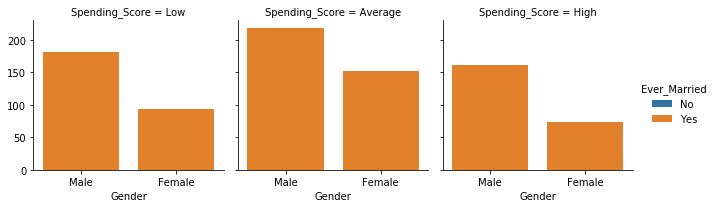

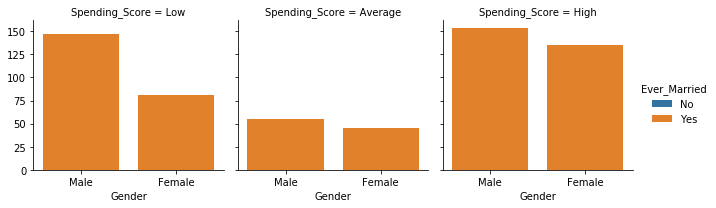

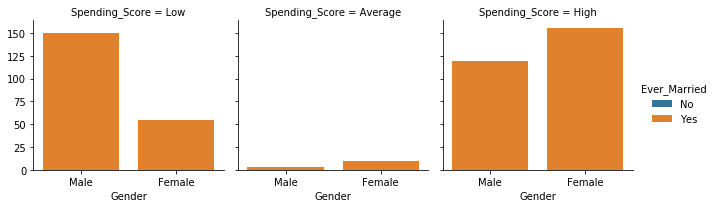

In [13]:
%matplotlib inline
age_ranges = [np.arange(18,28), np.arange(28,38), np.arange(38,48), np.arange(48,58), np.arange(58,68), np.arange(68,78), np.arange(78,90)]

# EDA for Marriage Status trend across demographics
for age in age_ranges:
    df = combined_df[combined_df['Age'].isin(age)]
    g = sns.FacetGrid(col='Spending_Score', hue='Ever_Married', col_order=['Low','Average','High'], hue_order=['No','Yes'], data=df)
    g.map(sns.countplot, 'Gender', order=['Male','Female'])
    g.add_legend()
    plt.show()

In [14]:
# Impute Ever_Married based on chart
'''
Everyone older than 48 is Yes
Every female younger than 48 who is Low Spender is No
Every male younger than 38 who is Low Spender is No
The rest is Yes
'''

# Everyone older than 48 is Yes
combined_df.loc[(combined_df['Ever_Married'].isnull()) & (combined_df['Age'] >= 48), 'Ever_Married'] = 'Yes'

# Females younger than 48 & Males younger than 38 who are Low Spenders is No
condition_married = (combined_df['Ever_Married'].isnull()) & (combined_df['Age'] < 48) & (combined_df['Spending_Score'] == 'Low')\
                    & ((combined_df['Gender'] == 'Female') | (combined_df['Age'] < 38))
combined_df.loc[condition_married, 'Ever_Married'] = 'No'

# The remaining is Yes
combined_df.loc[combined_df['Ever_Married'].isnull(), 'Ever_Married'] = 'Yes'

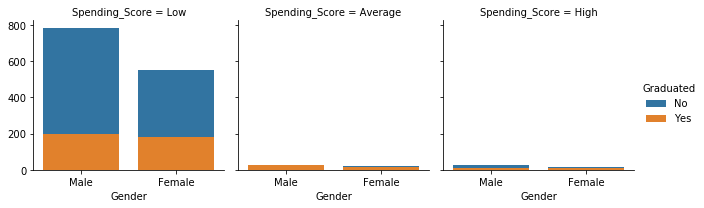

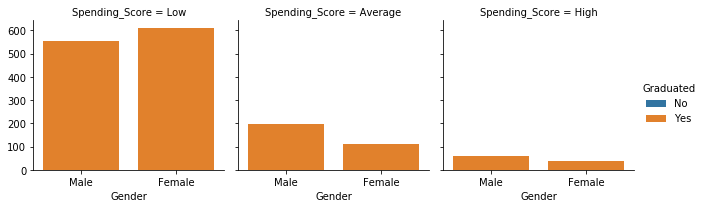

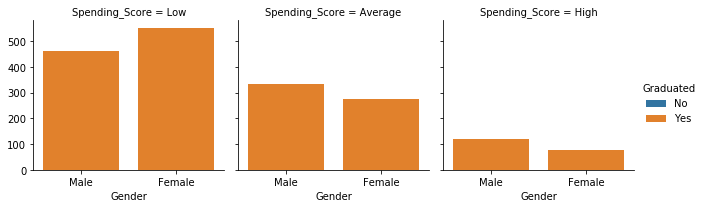

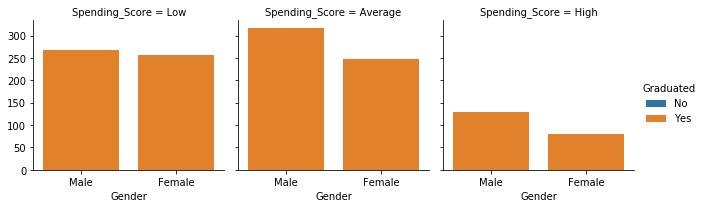

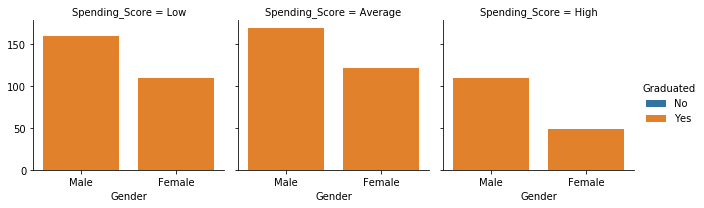

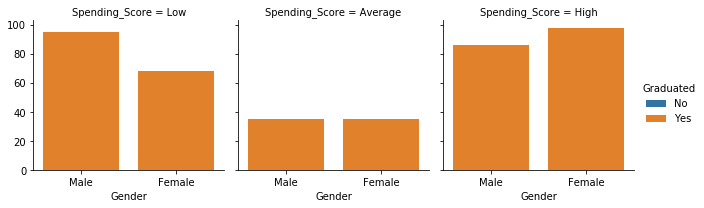

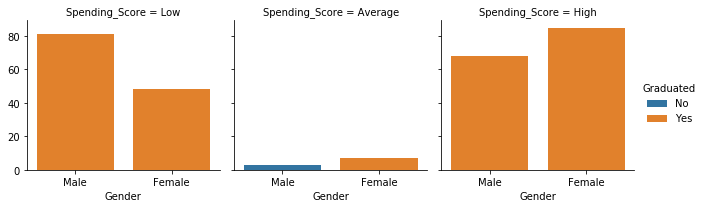

In [15]:
# EDA for Graduation Status trend across demographics
for age in age_ranges:
    df = combined_df[combined_df['Age'].isin(age)]
    g = sns.FacetGrid(col='Spending_Score', hue='Graduated', col_order=['Low','Average','High'], hue_order=['No','Yes'], data=df)
    g.map(sns.countplot, 'Gender', order=['Male','Female'])
    g.add_legend()
    plt.show()

In [16]:
# Impute Graduated based on chart
'''
Everyone Low Spender younger than 28 is No
Every male Average Spender older than 77 is No
The rest is Yes
'''

# Every Low Spender younger than 28 is No
combined_df.loc[(combined_df['Graduated'].isnull()) & (combined_df['Age'] < 28) & (combined_df['Spending_Score'] == 'Low'), 'Graduated'] = 'No'

# Every male Average Spender older than 77 is No
combined_df.loc[(combined_df['Graduated'].isnull()) & (combined_df['Age'] > 77) & (combined_df['Gender'] == 'Male')\
                & (combined_df['Spending_Score'] == 'Average'), 'Graduated'] = 'No'

# The rest is Yes
combined_df.loc[(combined_df['Graduated'].isnull()), 'Graduated'] = 'Yes'

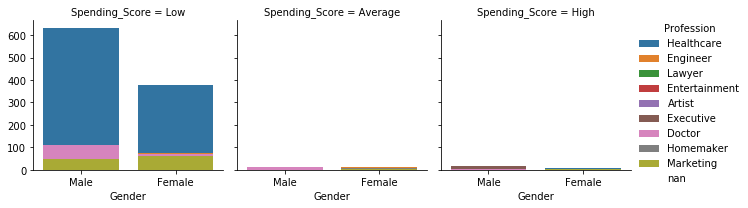

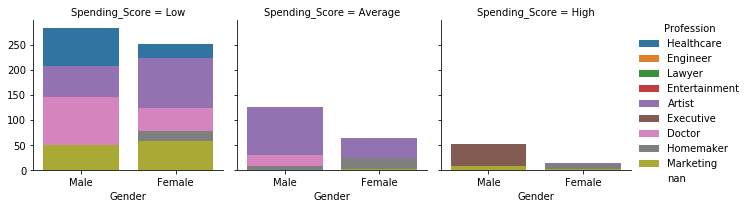

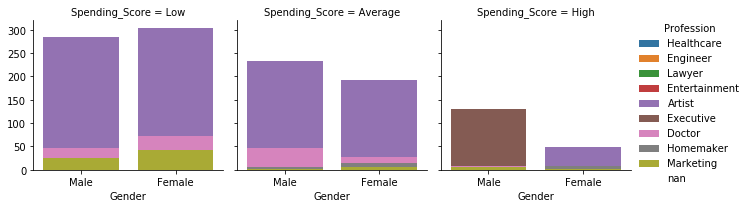

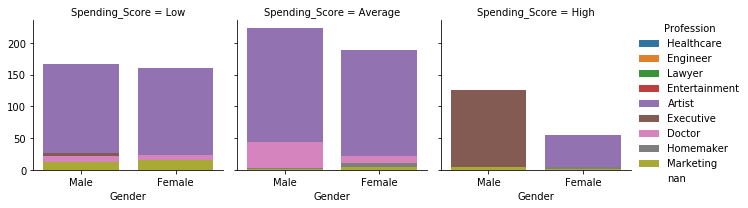

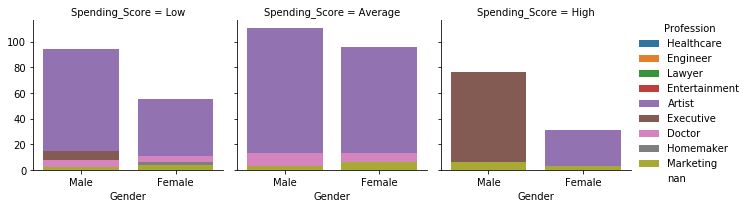

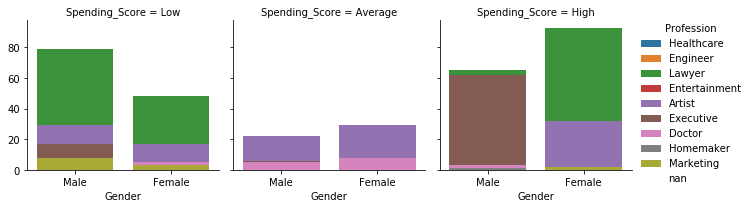

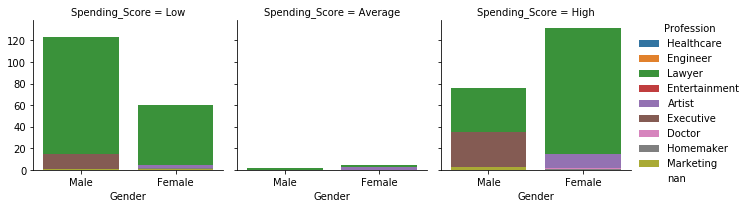

In [17]:
# EDA for Profession trend across demographics
for age in age_ranges:
    df = combined_df[combined_df['Age'].isin(age)]
    g = sns.FacetGrid(col='Spending_Score', hue='Profession', col_order=['Low','Average','High'], hue_order=combined_df['Profession'].unique(), data=df)
    g.map(sns.countplot, 'Gender', order=['Male','Female'])
    g.add_legend()
    plt.show()

In [18]:
'''
Every Low Spender younger than 28 is Healthcare
Every Low and Average Spender 38 - 67 is Artist
Every High Spender Female 38 - 67 is Artist
Every High Spender Male younger than 78 is Executive
Every Low Spender 78 - 90 is Lawyer
Every High Spender Female 78-90 is Lawyer
The rest are pretty random so filled using ffill/bfill
'''

# Every Low Spender younger than 28 is Healthcare
combined_df.loc[(combined_df['Profession'].isnull()) & (combined_df['Age'] < 28) & (combined_df['Spending_Score'] == 'Low'), 'Profession'] = 'Healthcare'

# Everyone Low and Average Spender OR High Spender Female Age 38 - 67 is Artist
condition_profession = (combined_df['Profession'].isnull()) & ((combined_df['Age'] >= 38) & (combined_df['Age'] <= 67))\
                       & ((combined_df['Spending_Score'] == 'Low') | (combined_df['Spending_Score'] == 'Average') 
                       | ((combined_df['Spending_Score'] == 'High') & (combined_df['Gender'] == 'Female')))
combined_df.loc[condition_profession, 'Profession'] = 'Artist' 

# Every High Spender Male younger than 78 is Executive
combined_df.loc[(combined_df['Profession'].isnull()) & (combined_df['Age'] < 78) & (combined_df['Spending_Score'] == 'High')
                & (combined_df['Gender'] == 'Male'), 'Profession'] = 'Executive'

# Everyone Low Spender OR High Spender Female Age 78 - 90 is Lawyer
condition_profession_2 = (combined_df['Profession'].isnull()) & ((combined_df['Age'] >= 78) & (combined_df['Age'] <= 90))\
                         & ((combined_df['Spending_Score'] == 'Low') | ((combined_df['Gender'] == 'Female') & (combined_df['Spending_Score'] == 'High')))
combined_df.loc[condition_profession_2, 'Profession'] = 'Lawyer'

# The rest using ffill
combined_df['Profession'].fillna(method='ffill', inplace=True)

In [19]:
# For Var_1 use ffill because from the graph Cat_6 dominates every category
combined_df['Var_1'].fillna(method='ffill', inplace=True)

Imputing Work Experience and Family Size using the Mean Value

In [20]:
# Copy dataframe to decide impute value for Work Experience
workexp_df = combined_df.copy()
workexp_df = workexp_df.dropna(subset=['Work_Experience'])

# Decide impute value for Work Experience
workexp_df = workexp_df.groupby(['Gender','Graduated','Spending_Score','Age'])['Work_Experience'].mean()
workexp_df = workexp_df.unstack(level=[0,1,2]).reset_index()

# Divide age into ranges
workexp_df = workexp_df.groupby(pd.cut(workexp_df.Age, np.arange(17,98,10))).mean().drop(columns='Age')
display(workexp_df)

c:\users\luthf\appdata\local\programs\python\python38\lib\site-packages\pandas\core\generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Gender            Female                                                    \
Graduated             No                           Yes                       
Spending_Score   Average      High       Low   Average      High       Low   
Age                                                                          
(17, 27]        5.101190  4.416667  2.563744  4.435714  6.277778  2.228560   
(27, 37]        3.503704  3.333333  3.590174  2.903522  5.824074  3.764136   
(37, 47]        3.355920  1.447917  3.270763  2.950925  3.450485  3.480391   
(47, 57]        2.690741  3.345238  2.535281  1.872374  1.673457  2.000111   
(57, 67]        1.566667  1.722222  2.259259  1.547044  0.904798  1.875736   
(67, 77]        3.083333  0.750000  1.535714  0.741667  1.649452  0.864214   
(77, 87]        1.666667  0.676667  0.566667  2.333333  1.435000  0.883333   
(87, 97]             NaN  0.888889  1.000000  3.500000  0.687500  0.916667   

Gender              Male                                                    
Graduated             No                           Yes                      
Spending_Score   Average      High       Low   Average      High       Low  
Age                                                                         
(17, 27]        3.020000  3.060417  2.408193  3.306818  4.694444  2.319875  
(27, 37]        3.096249  3.172222  2.486060  3.562956  6.401235  3.466261  
(37, 47]        2.199771  3.479473  2.303028  2.843748  2.825331  2.974363  
(47, 57]        1.415737  1.636772  1.114109  1.687486  2.170319  1.737183  
(57, 67]        1.607099  1.440741  2.464286  1.354271  1.784259  1.716650  
(67, 77]        0.979167  0.712738  0.912323  1.095238  1.046429  1.445250  
(77, 87]        2.000000  1.228333  1.256667       NaN  0.641667  1.162500  
(87, 97]             NaN  0.333333  0.958333       NaN  1.547619  2.625000

In [21]:
# Fill in null Work Experience Value in the original combined_df dataset based on values in workexp_df
for gender in combined_df['Gender'].unique():
    for grad in combined_df['Graduated'].unique():
        for score in combined_df['Spending_Score'].unique():
            age_index = 0
            for age in workexp_df.index:
                condition = (combined_df['Gender'] == gender) & (combined_df['Graduated'] == grad) & (combined_df['Spending_Score'] == score)\
                & (combined_df['Age'].isin(np.arange(age.left+1, age.right+1))) & (combined_df['Work_Experience'].isnull())
                index = combined_df[condition].index.tolist()
                combined_df['Work_Experience'][index] = round(workexp_df[(gender,grad,score)].iloc[age_index], 2)
                age_index += 1

<ipython-input-21-75e23eb62f2e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['Work_Experience'][index] = round(workexp_df[(gender,grad,score)].iloc[age_index], 2)


In [22]:
# Copy dataframe to decide impute value for Family Size
famsize_df = combined_df.copy()
famsize_df = famsize_df.dropna(subset=['Family_Size'])

# Decide impute value for Work Experience
famsize_df = famsize_df.groupby(by=['Gender','Ever_Married','Graduated', 'Age'])['Family_Size'].mean()
famsize_df = famsize_df.unstack(level=[0,1,2]).reset_index()

# Divide age into ranges
famsize_df = famsize_df.groupby(pd.cut(famsize_df.Age, np.arange(17,98,10))).mean().drop(columns='Age')
display(famsize_df)

c:\users\luthf\appdata\local\programs\python\python38\lib\site-packages\pandas\core\generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Gender          Female                                    Male            \
Ever_Married        No                 Yes                  No             
Graduated           No       Yes        No       Yes        No       Yes   
Age                                                                        
(17, 27]      3.816123  3.175694  2.585648  2.833824  3.890214  3.215251   
(27, 37]      3.060635  2.684042  3.102421  2.518784  3.462255  2.669955   
(37, 47]      1.932492  1.669112  3.013088  2.582761  2.349206  1.834164   
(47, 57]      1.487500  1.362903  3.138157  2.953410  1.729167  1.785714   
(57, 67]      1.466667  1.504630  3.178724  2.662850  1.500000  1.873333   
(67, 77]      2.000000  1.904762  2.094291  2.075244  2.125000  1.600000   
(77, 87]      2.500000  1.500000  1.856389  1.886147  1.000000  1.500000   
(87, 97]           NaN  1.000000  1.833333  2.115385       NaN       NaN   

Gender                            
Ever_Married       Yes            
Graduated           No       Yes  
Age                               
(17, 27]      3.806124  2.892303  
(27, 37]      3.169334  2.594864  
(37, 47]      3.567677  2.896038  
(47, 57]      3.450640  2.956973  
(57, 67]      2.712086  2.548425  
(67, 77]      2.255547  1.968671  
(77, 87]      1.644024  1.772799  
(87, 97]      1.607143  1.816667

In [23]:
for gender in combined_df['Gender'].unique():
    for marriage in combined_df['Ever_Married'].unique():
        for grad in combined_df['Graduated'].unique():
            age_index = 0
            for age in famsize_df.index:
                condition = (combined_df['Gender'] == gender) & (combined_df['Ever_Married'] == marriage) & (combined_df['Graduated'] == grad)\
                & (combined_df['Age'].isin(np.arange(age.left+1, age.right+1))) & (combined_df['Family_Size'].isnull())
                index = combined_df[condition].index.tolist()
                combined_df['Family_Size'][index] = round(famsize_df[(gender,marriage,grad)].iloc[age_index], 2)
                age_index += 1

<ipython-input-23-044a061e0bb7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['Family_Size'][index] = round(famsize_df[(gender,marriage,grad)].iloc[age_index], 2)


In [24]:
count_null(combined_df)

Column Family_Size has 1 null values. Data type FLOAT64
Column Segmentation has 2627 null values. Data type OBJECT


In [25]:
# Remaining 1 Family Size null (because the demographic data doesn't fit any available data). Just use ffill
combined_df['Family_Size'].fillna(method='ffill', inplace=True)
count_null(combined_df)

Column Segmentation has 2627 null values. Data type OBJECT


In [26]:
from sklearn.preprocessing import LabelEncoder

<center><h3><i>Feature Engineering</i></h3></center>

In [27]:
categorical_columns = ['Gender','Ever_Married','Graduated','Profession','Spending_Score','Var_1']
combined_df_encoded = combined_df.copy()

for col in categorical_columns:
    le = LabelEncoder()
    combined_df_encoded[col] = le.fit_transform(combined_df_encoded[col].astype('str'))

In [28]:
train_df_encoded = combined_df_encoded[combined_df_encoded['is_train'] == 1].drop(['ID', 'is_train'], axis=1)
test_df_encoded = combined_df_encoded[combined_df_encoded['is_train'] == 0]

In [29]:
X = train_df_encoded.drop(['Segmentation'], axis=1)
y = train_df_encoded['Segmentation']

In [30]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score

In [31]:
cv = RepeatedStratifiedKFold(n_repeats=2, random_state=7)
lgb_model_1 = LGBMClassifier(reg_lambda=1, reg_alpha=1, random_state=100)
cv_score = cross_val_score(lgb_model_1, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
np.mean(cv_score)

0.5286929847406182

In [32]:
X_test = test_df_encoded.drop(['ID', 'Segmentation', 'is_train'], axis=1) 

In [33]:
lgb_model_1.fit(X,y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=100, reg_alpha=1, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [34]:
y_test_pred = lgb_model_1.predict(X_test)

In [35]:
test_df_encoded['Segmentation'] = y_test_pred
submission_df = test_df_encoded[['ID','Segmentation']]

<ipython-input-35-d9af5efefa6a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_encoded['Segmentation'] = y_test_pred


In [36]:
submission_df.to_csv('submission.csv', index=False)

In [37]:
from xgboost import XGBClassifier

In [39]:
xgb_hyperparams = {'reg_alpha':[0,1],
                   'reg_lambda':[0,1],
                   'learning_rate':[0.1,0.15]}
xgb_model = XGBClassifier()
xgb_random_search = RandomizedSearchCV(xgb_model, xgb_hyperparams)

In [40]:
xgb_random_search.fit(X,y)

c:\users\luthf\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_search.py:277: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\users\luthf\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:18:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:18:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:18:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:18:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=Non...
                                           reg_lambda=None,
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
                     

In [41]:
xgb_random_search.best_params_

{'reg_lambda': 0, 'reg_alpha': 1, 'learning_rate': 0.1}

In [42]:
xgb_random_search.best_score_

0.5333432435193913